In [203]:
from __future__ import print_function
import numpy as np # Biblioteca de funciones matematicas de alto nivel
np.random.seed(1337)  # for reproducibility
import tensorflow as tf
import keras  
import pandas as pd

In [204]:
dataset = pd.read_csv('Train.csv', encoding = "ISO-8859-1") # lectura de datos
dataset1 = pd.read_csv('Test.csv', encoding = "ISO-8859-1") # lectura de datos


In [205]:
dataset.replace([np.inf, -np.inf], -1, inplace=True) 
dataset.replace([np.nan, -np.nan], -1, inplace=True)

dataset1.replace([np.inf, -np.inf], -1, inplace=True) 
dataset1.replace([np.nan, -np.nan], -1, inplace=True)

In [206]:
# Eliminamos los datos mal introducidos
dataset = dataset.drop(dataset[dataset['Dst Port']=='Dst Port'].index)
dataset1 = dataset1.drop(dataset1[dataset1['Dst Port']=='Dst Port'].index)

dataset = dataset[dataset['Flow IAT Min'] >= 0]
dataset1 = dataset1[dataset1['Flow IAT Min'] >= 0]
#Eliminamos las columnas innecesarias

dataset = dataset.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP','Unnamed: 0','Dst Port','Fwd Seg Size Min',
                       'Idle Min','Idle Mean','Idle Std','Idle Max'], axis=1)
dataset1 = dataset1.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP','Unnamed: 0','Dst Port','Fwd Seg Size Min',
                          'Idle Min','Idle Mean','Idle Std','Idle Max'], axis=1)
#Quitamos direcciones IP dest y src para no introducir sesgos, lo mismo con los puertos
#Quitar el puerto de destino es una modificación con respecto al trabajo original
#Eliminamos la columna de timestamp para no tener sesgo
dataset1 = dataset1.drop(['Timestamp'], axis=1)
dataset = dataset.drop(['Timestamp'], axis=1)

#Eliminamos la columna 
dataset

,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Active Mean,Active Std,Active Max,Active Min,Label
0,6,3025021,11,15,336.0,188.0,79.0,0.0,30.545455,38.624768,...,0,7,64240,181,6,0,0,0,0,FTP-BruteForce
1,6,468,2,1,79.0,0.0,79.0,0.0,39.500000,55.861436,...,0,0,502,0,0,0,0,0,0,FTP-BruteForce
2,6,3054906,13,15,338.0,188.0,79.0,0.0,26.000000,36.398260,...,0,6,64240,181,6,0,0,0,0,FTP-BruteForce
3,6,3046116,11,15,341.0,188.0,79.0,0.0,31.000000,38.348403,...,0,7,64240,181,6,0,0,0,0,FTP-BruteForce
4,6,3045413,13,15,351.0,188.0,86.0,0.0,27.000000,37.678464,...,0,6,64240,181,6,0,0,0,0,FTP-BruteForce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430151,17,9264,1,1,47.0,63.0,47.0,47.0,47.000000,0.000000,...,0,31,0,0,0,0,0,0,0,Benign
430152,0,91444297,51,0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,Benign
430153,17,101164777,6,6,1332.0,1032.0,222.0,222.0,222.000000,0.000000,...,0,86,0,0,5,0,0,0,0,Benign
430154,17,101009912,6,6,1332.0,1032.0,222.0,222.0,222.000000,0.000000,...,0,86,0,0,5,0,0,0,0,Benign


In [207]:
n=0
for column in dataset:
    column
    if column != 'Label':
        dataset[column] = dataset[column].astype(float)
        
n=0
for column in dataset1:
    column
    if column != 'Label':
        dataset1[column] = dataset1[column].astype(float)


In [208]:
#dataset.loc[(dataset.Label != 'Benign'),'Label']='Evil'
#dataset1.loc[(dataset1.Label != 'Benign'),'Label']='Evil'
# Solo se utiliza para detectar malo o bueno

#dataset = dataset.drop(dataset[dataset['Label'] == 'Evil'].sample(frac=.8).index)
#dataset1 = dataset1.drop(dataset1[dataset1['Label'] == 'Evil'].sample(frac=.8).index)



In [209]:
Labels = dataset['Label'].unique()
Y_train = dataset["Label"]
Y_test =  dataset1["Label"]

In [210]:
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt

aux_train =dataset.iloc[:, 0:72]
aux_test = dataset.iloc[:, 0:72]

X_train=dataset.iloc[:, 0:72] #Luego obtenemos las características del flujo
X_test=dataset1.iloc[:, 0:72]

sel = VarianceThreshold(threshold=0)
hola=sel.fit_transform(X_train)

aux=X_train.var()

for col in X_train.columns:
    if X_train[col].var() == 0:
        print(col)
        X_train=X_train.drop(col, axis =1)
        X_test=X_test.drop(col, axis =1)
       
        #Aqui iria un drop

#plt.figure(figsize=(40, 10))
cor = X_train.corr().abs()
#sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
#plt.show()



ranking = pd.read_csv("rankingSHAP.txt")



#plt.savefig('save_as_a_png.png')
#pintar solo con colores


Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
URG Flag Cnt
CWE Flag Count
ECE Flag Cnt
Fwd Byts/b Avg
Fwd Pkts/b Avg
Fwd Blk Rate Avg
Bwd Byts/b Avg
Subflow Bwd Pkts
Active Mean
Active Std
Active Max
Active Min


In [211]:
from sklearn.preprocessing import LabelEncoder
 
lb_make = LabelEncoder()
Y_train = lb_make.fit_transform(Y_train) #para pasar a numeros


Labels = lb_make.inverse_transform(Y_train)
Labels = list(lb_make.classes_)

In [212]:
lb_make = LabelEncoder()
Y_test = lb_make.fit_transform(Y_test)

Labels1 = lb_make.inverse_transform(Y_test)
Labels1 = list(lb_make.classes_)

In [213]:
umbral = 1
data = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
tabla_datos=pd.DataFrame(data, columns=["umbral"])
tabla_datos["variables"]=tabla_datos["umbral"]
tabla_datos["precision"]=tabla_datos["variables"]
tabla_datos["tiempo_ent"]=tabla_datos["variables"]
tabla_datos["tiempo_pred"]=tabla_datos["variables"]
tabla_datos["tasa"]=tabla_datos["variables"]
print(X_test.shape[0])

101815


In [214]:
#print(cor.iloc[:,0])
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

hache=0

#while umbral > 0:
corr_matrix = cor
X_trainAux=X_train
X_testAux=X_test
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

umbral = 0.30
to_drop = [column for column in upper.columns if any(upper[column] > umbral)]

lista_variables=[]

for i in range(len(to_drop)):
    lista_borrar=[]
    indices=upper.index[upper[to_drop[i]] > umbral ].tolist()
    indices.append(to_drop[i])

    #print(indices)
    for j in range(len(indices)):
        pos=ranking.index[ranking.eq(indices[j]).any(1)].tolist()
        lista_borrar.append(pos)

    minimum = min(lista_borrar)
    lista_borrar.remove(minimum)
    for k in range(len(lista_borrar)):
        lista_variables.append(ranking.Caracteristicas[lista_borrar[k]].tolist())

for i in range(len(lista_variables)):
    col=lista_variables[i][0]
    try:
        X_trainAux=X_trainAux.drop(col, axis =1)
        X_testAux=X_testAux.drop(col, axis =1)
        #print(col)
    except:
            lista=0

inicio = time.time()
#model = make_pipeline(
#StandardScaler(),
#MLPClassifier(hidden_layer_sizes=(16,12),activation='relu', max_iter=500,random_state=0)
 #)       


X_trainArr=X_trainAux.to_numpy()


#model.fit(X_trainArr,Y_train)
fin = time.time()
tiempo=fin-inicio

variables= X_trainAux.shape[1]

X_testArr=X_testAux.to_numpy()

inicio = time.time()
Y_pred=model.predict(X_testArr)
fin = time.time()
tiempo_prediccion=fin-inicio

accuracy_modelo=accuracy_score(Y_test, Y_pred)

tabla_datos["umbral"][hache]=umbral
tabla_datos["variables"][hache]=variables
tabla_datos["precision"][hache]=accuracy_modelo
tabla_datos["tiempo_ent"][hache]=tiempo
tabla_datos["tiempo_pred"][hache]=tiempo_prediccion
tabla_datos["tasa"][hache]=101815/tiempo_prediccion
hache=hache+1

umbral=umbral-0.05
     
#plt.figure(figsize=(10, 7))
#corr_matrix = X_trainAux.corr().abs()
#sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
#plt.show()

lista_variables=[]
lista_borrar=[]

#plt.savefig('save_as_a_png.pdf')
#poner a cero los que no molen
#sustituir por 100 cada una que tenga 100 fuera

features = list(X_trainAux.columns)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set o

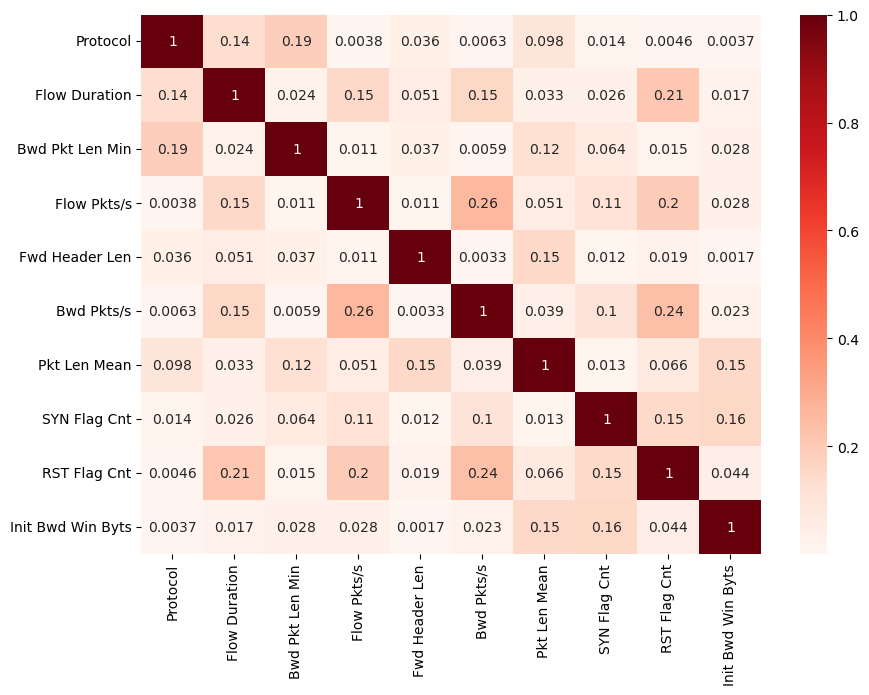

In [215]:
plt.figure(figsize=(10, 7))
cor = X_trainAux.corr().abs()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [218]:
size=200
data=shap.sample(X_trainArr, size)
explainer = shap.KernelExplainer(model.predict,data)
expected_value = explainer.expected_value
data1=shap.sample(X_testArr, size)
shap_values = explainer.shap_values(data1,nsamples=size)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [219]:
np.savetxt('testV3.1FCBF.txt',shap_values)


#shap_values = np.loadtxt('testV3.1.txt')
print(shap_values.shape)

(200, 10)


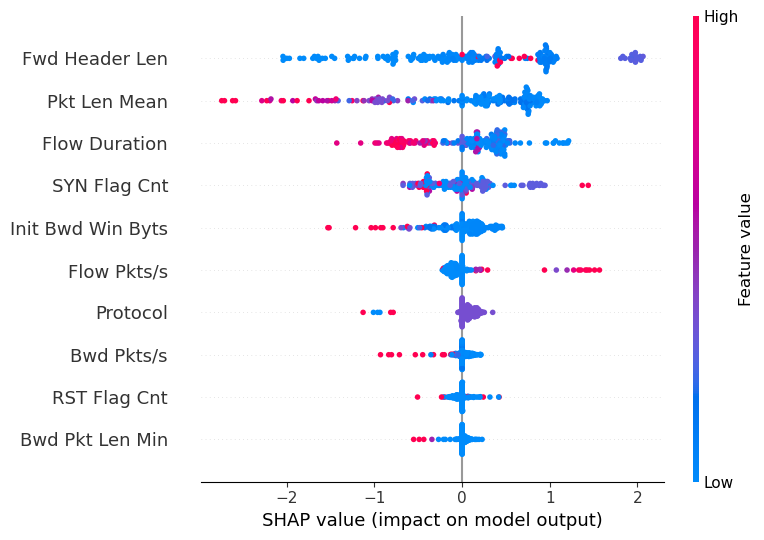

In [220]:
shap.summary_plot(shap_values,data1,feature_names=features, max_display=57)

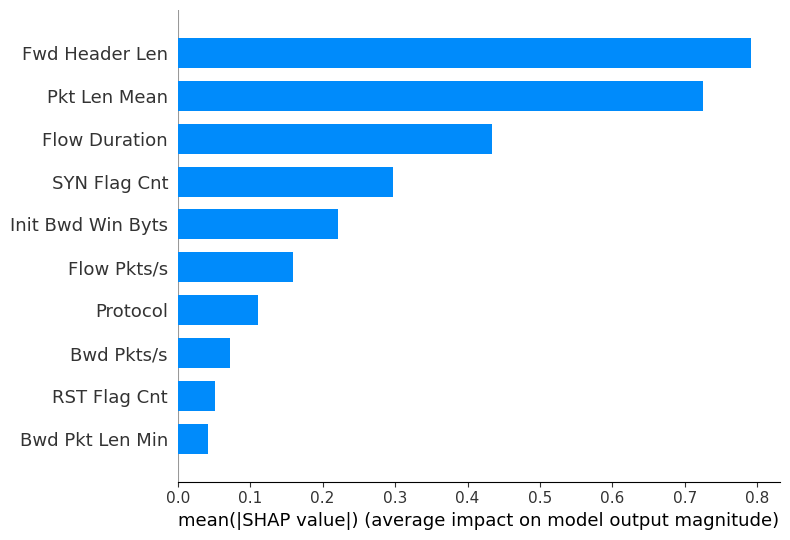

In [221]:
shap.summary_plot(shap_values, X_testAux, plot_type="bar", feature_names = features, max_display=65)

SSH-Bruteforce


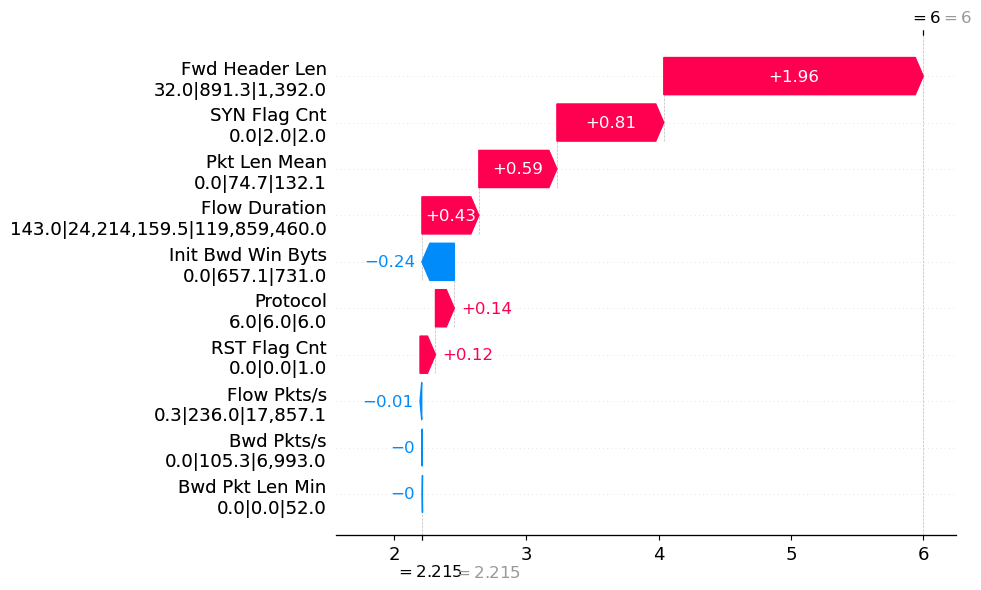

In [240]:
#0-Bening
#1-DoS attacks-GoldenEye
#2-DoS attacks-Hulk
#3-'DoS attacks-SlowHTTPTest
#4-'DoS attacks-Slowloris
#5'FTP-BruteForce,
#6'SSH-Bruteforce
nuevo_shap=shap_values[0]*0
nuevo_data = data1[0]*0
nuevo_min=data1[0]
nuevo_max=nuevo_data
nuevo_std=nuevo_data

acum=0
ata=6


margen=0.2
for i in range(size):
    suma=shap_values[i].sum()+explainer.expected_value
    if  (suma > (ata-abs(margen)))  and (suma < (ata+abs(margen))):
        nuevo_shap=nuevo_shap+shap_values[i]
        nuevo_data=nuevo_data+data1[i]
        nuevo_min =np.minimum(nuevo_min,data1[i])
        nuevo_max =np.maximum(nuevo_max,data1[i])
        acum=acum+1
nuevo_shap=nuevo_shap/acum
nuevo_data=nuevo_data/acum
#Calculo del STD
for i in range(size):
    suma=shap_values[i].sum()+explainer.expected_value
    if  (suma > (ata-abs(margen)))  and (suma < (ata+abs(margen))):
        
        nuevo_std= nuevo_std+((data1[i]-nuevo_data)**2)
       
nuevo_std = (nuevo_std/acum)**0.5

#print('{0:,}'.format(int(nuevo_max[1])))
#"|" + '{0:,}'.format(int(e)) 
feature = [a + "\n" + '{0:,}'.format(b) +"|" +'{0:,}'.format(c) +"|" +'{0:,}'.format(d)
           for a,b,c,d in zip(features,dataset.loc[dataset['Label'] == Labels[ata],features].min().round(1),
                                dataset.loc[dataset['Label'] == Labels[ata],features].mean().round(1),
                                dataset.loc[dataset['Label'] == Labels[ata],features].max().round(1),
                               )]
print(Labels[ata])
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, nuevo_shap,feature_names=feature, max_display=11)

#shap.summary_plot(shap_values, data1, plot_type="bar", class_names= Labels1, feature_names = features)
#Revisar que significa el explainer expecteed value

In [227]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn import tree


In [228]:
#clf = tree.DecisionTreeClassifier(random_state=0)
n_estimators=200
clf = RandomForestClassifier(random_state=0,n_estimators=n_estimators,max_depth=3)
#    max_features
inicio = time.time()
clf = clf.fit(X_trainArr,Y_train)
fin = time.time()
tiempo_random = fin-inicio
print(tiempo_random)

46.95276069641113


In [229]:
X_testArr = X_test.to_numpy()
Y_pred=clf.predict(X_trainArr)
LabelsArr = np.array(Labels)

y_testree1 = []
for i in range(0, Y_train.size):
    for j in range(0, LabelsArr.size):
        if Y_train[i] == j:
            y_testree1.append(Labels[j])

y_predtree1 = []
for i in range(0, Y_pred.size):
    for j in range(0, LabelsArr.size):
        if Y_pred[i] == j:
            y_predtree1.append(Labels[j])

In [230]:
print(classification_report(y_testree1, y_predtree1, digits=8, zero_division= "warn"))
accuracy_modelo=accuracy_score(Y_train, Y_pred)
print(accuracy_modelo)
# 0.91882740 max 5

                          precision    recall  f1-score   support

                  Benign  0.83995856 0.94517719 0.88946700    120096
   DoS attacks-GoldenEye  0.87693906 0.71185434 0.78582007     52175
        DoS attacks-Hulk  0.84915738 0.54587971 0.66455263     50676
DoS attacks-SlowHTTPTest  0.98176055 0.72470658 0.83387288     53848
   DoS attacks-Slowloris  0.98931397 0.93308709 0.96037826     53876
          FTP-BruteForce  0.56869139 0.93913488 0.70840777     50883
          SSH-Bruteforce  0.99792337 0.93185305 0.96375718     46928

                accuracy                      0.83813789    428482
               macro avg  0.87196347 0.81881326 0.82946511    428482
            weighted avg  0.86723655 0.83813789 0.83881072    428482

0.8381378914400138


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

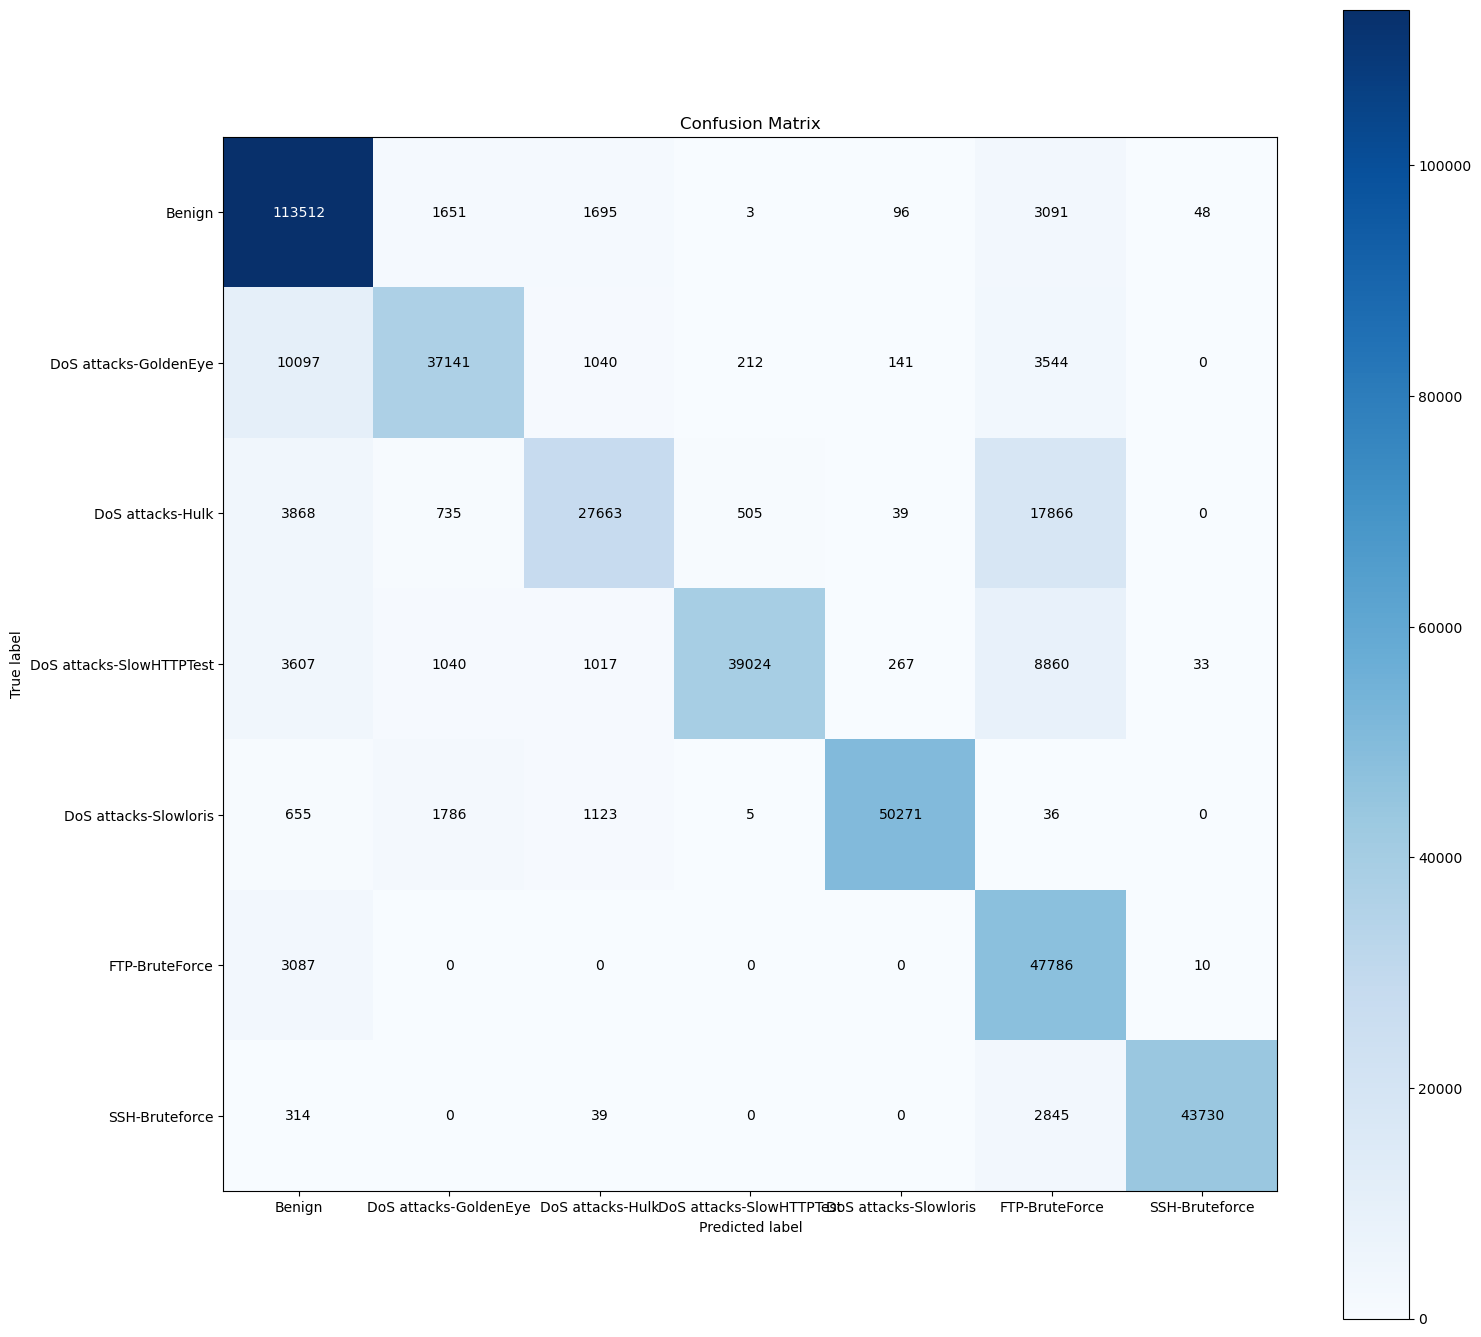

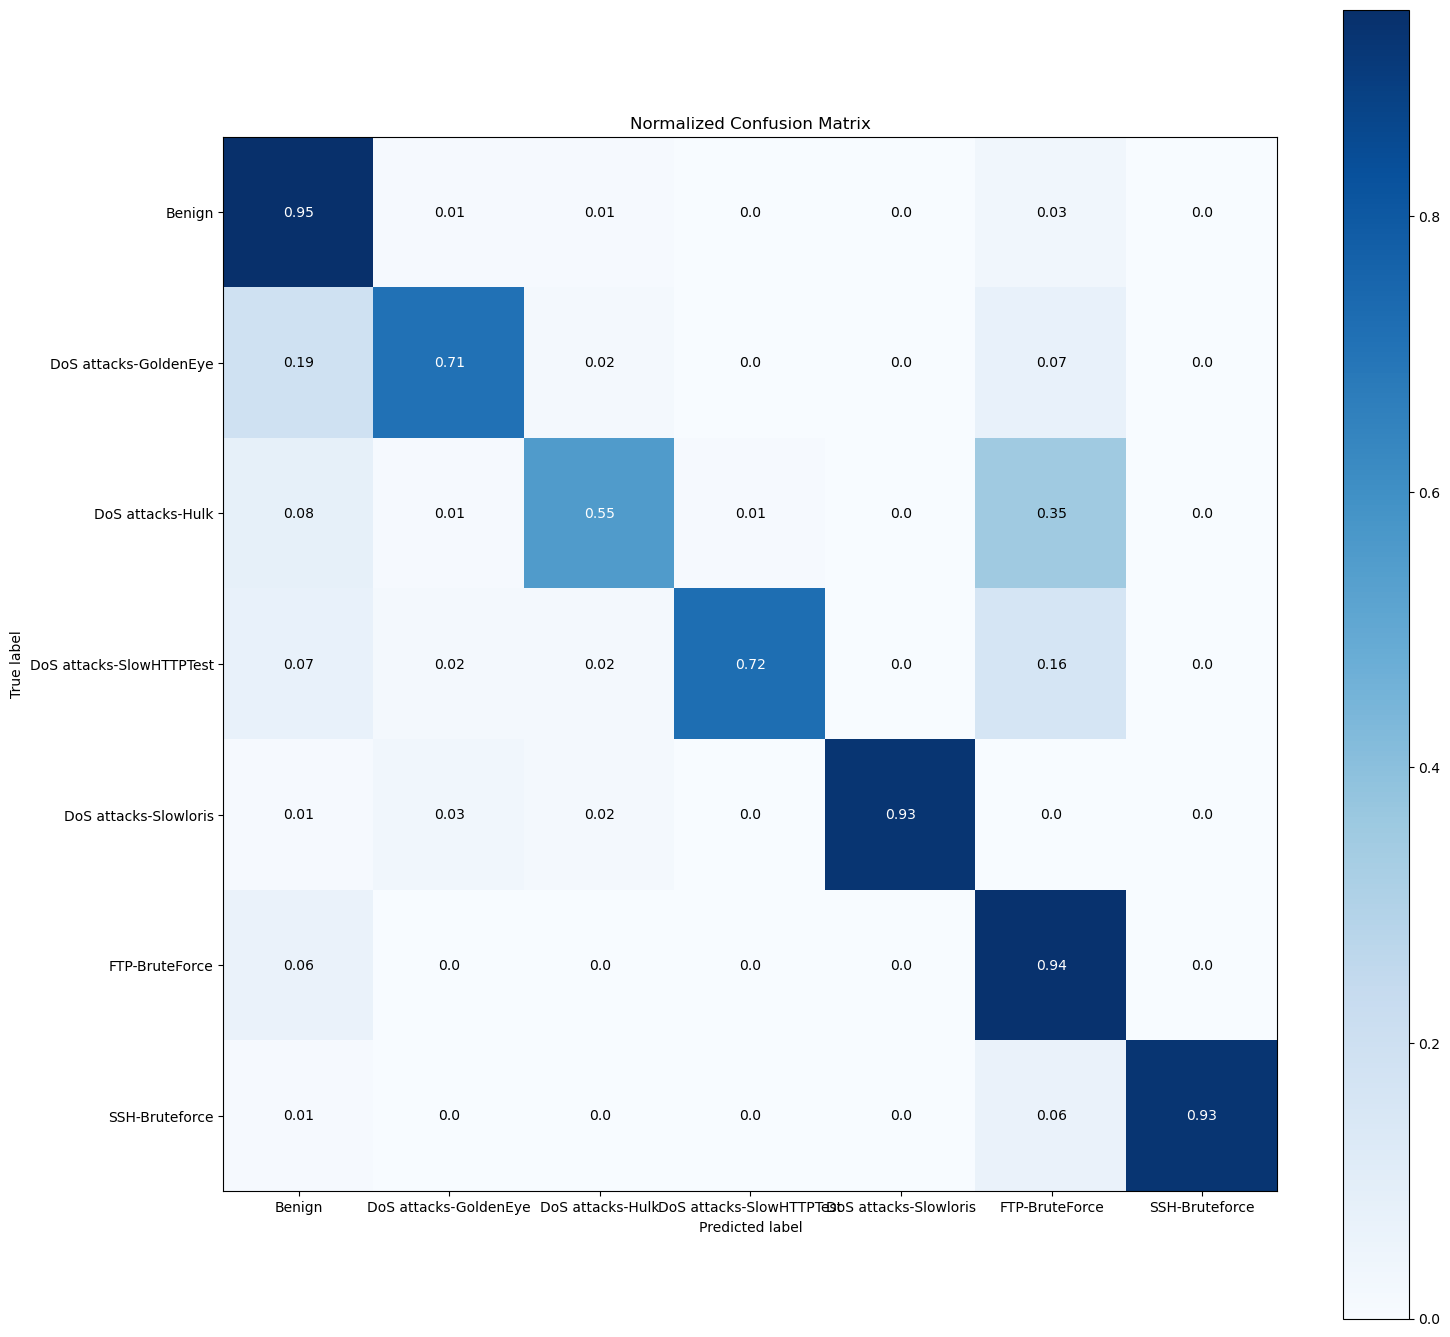

In [231]:
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1,figsize= (17,17))
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1, normalize= True,figsize= (17,17))

In [232]:
X_testArr = X_test.to_numpy()
Y_pred=clf.predict(X_testArr)
LabelsArr = np.array(Labels1)

y_testree1 = []
for i in range(0, Y_test.size):
    for j in range(0, LabelsArr.size):
        if Y_test[i] == j:
            y_testree1.append(Labels[j])

y_predtree1 = []
for i in range(0, Y_pred.size):
    for j in range(0, LabelsArr.size):
        if Y_pred[i] == j:
            y_predtree1.append(Labels[j])

ValueError: X has 57 features, but RandomForestClassifier is expecting 10 features as input.

In [ ]:
print(classification_report(y_testree1, y_predtree1, digits=8, zero_division= "warn"))


In [ ]:
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1,figsize= (17,17))
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1, normalize= True,figsize= (17,17))

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
accuracy_ant=0
accuracy_med=0
accuracy_pon=0
accuracy_pon_ant=0
best=0
dist_ant=1000
inicio = time.time()
from tqdm import tqdm
for i in range(n_estimators):
    aux_clf = clf.estimators_[i]
    y_pred_train=aux_clf.predict(X_trainArr)
    y_pred_test=aux_clf.predict(X_testArr)
    accuracy=accuracy_score(Y_test, y_pred_test)
    
    accuracy_train=accuracy_score(Y_train, y_pred_train)
    accuracy_pon = accuracy_train*accuracy
    
    if accuracy_pon > accuracy_pon_ant:
        pon=i
        accuracy_pon_ant=accuracy_pon
        accuracy_pon_train = accuracy_train
        accuracy_pon_test = accuracy
        arbol_tree=clf.estimators_[pon]
        
import time


fin = time.time()

print(fin-inicio)




In [ ]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(arbol_tree, out_file=None, feature_names=features,  
                               # class_names=Labels,
                               # filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph
#graph.render("decision_tree_graphivz7")

In [ ]:

Y_pred_train=arbol_tree.predict(X_trainArr)
Y_pred_test=arbol_tree.predict(X_testArr)
accuracy_train=accuracy_score(Y_train, y_pred_train)
accuracy_test=accuracy_score(Y_test, y_pred_test)
print("precision train: ",accuracy_train,"precision test: ",accuracy_test)

In [ ]:

Y_pred=arbol_tree.predict(X_testArr)
LabelsArr = np.array(Labels1)

y_testree1 = []
for i in range(0, Y_test.size):
    for j in range(0, LabelsArr.size):
        if Y_test[i] == j:
            y_testree1.append(Labels[j])

y_predtree1 = []
for i in range(0, Y_pred.size):
    for j in range(0, LabelsArr.size):
        if Y_pred[i] == j:
            y_predtree1.append(Labels[j])

In [ ]:

print(classification_report(y_testree1, y_predtree1, digits=8, zero_division= "warn"))

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

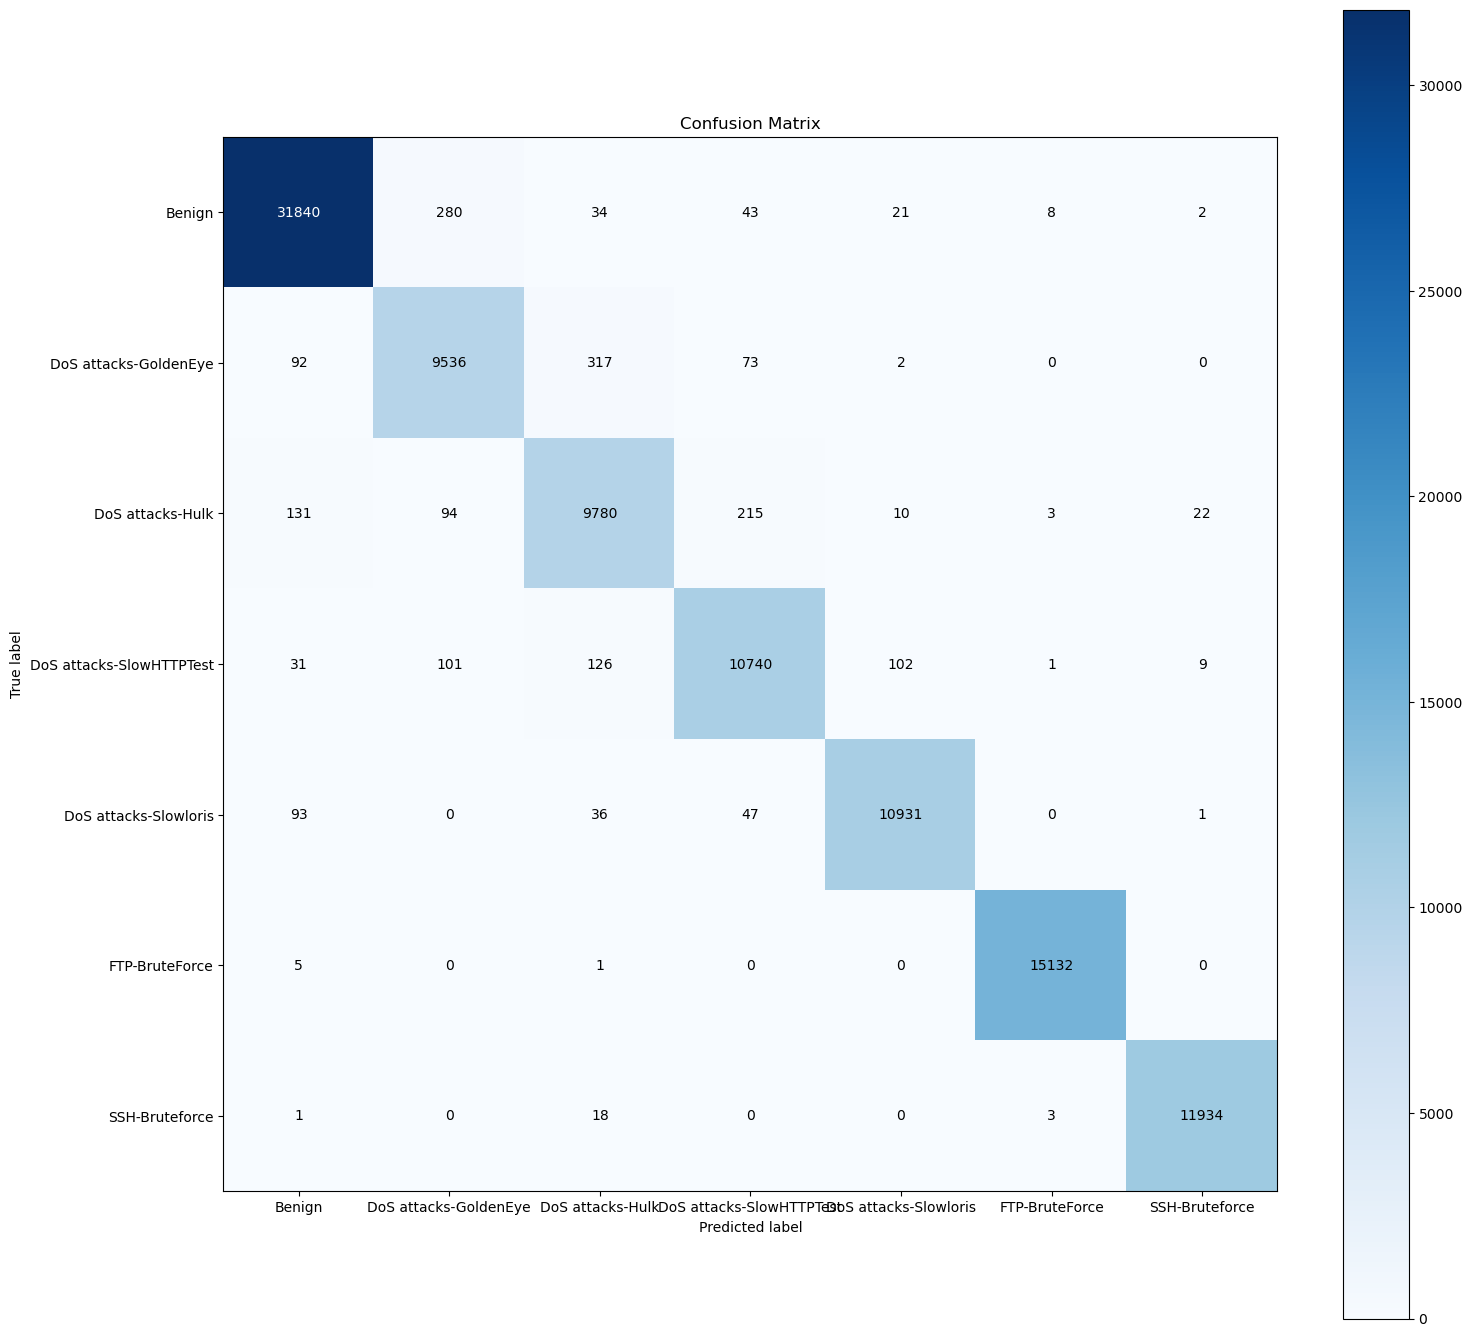

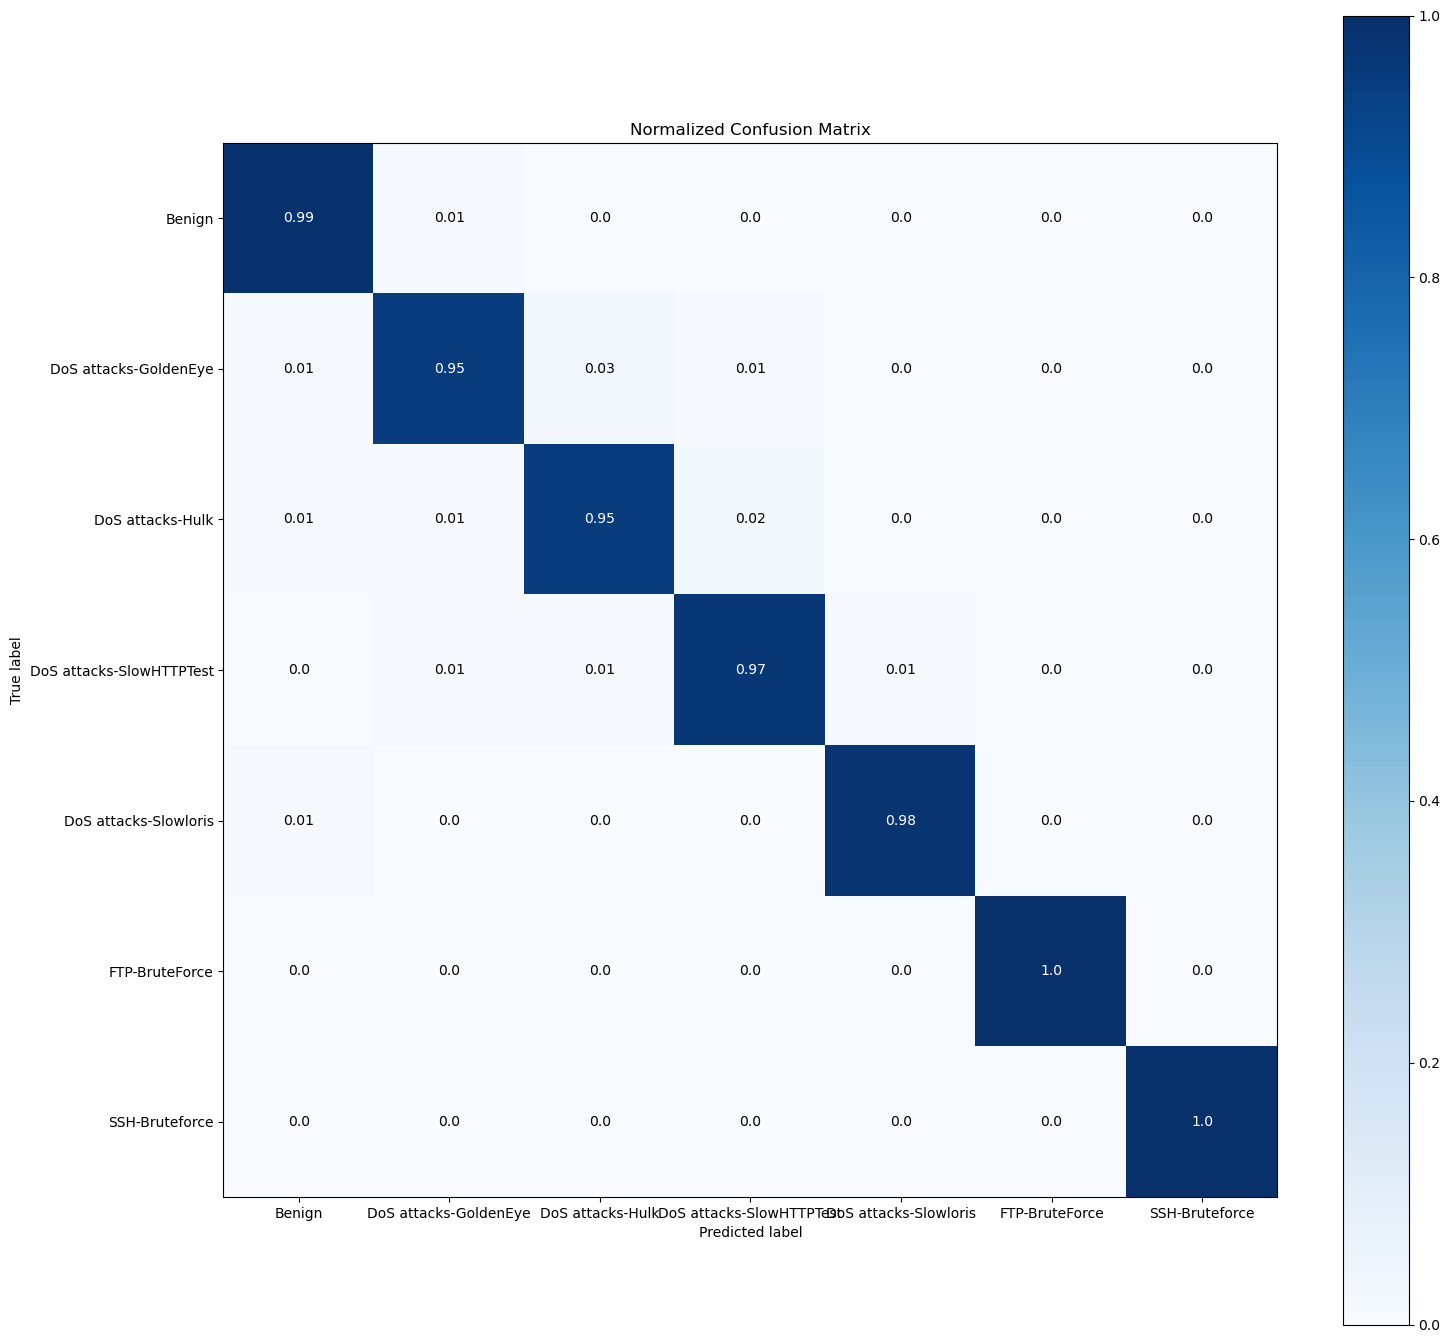

In [225]:
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1,figsize= (17,17))
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1, normalize= True,figsize= (17,17))


In [226]:
dataset0 = pd.read_csv('Train.csv', encoding = "ISO-8859-1") # lectura de datos
dataset01 = pd.read_csv('Test.csv', encoding = "ISO-8859-1") # lectura de datos

dataset0.replace([np.inf, -np.inf], -1, inplace=True) 
dataset0.replace([np.nan, -np.nan], -1, inplace=True)

dataset01.replace([np.inf, -np.inf], -1, inplace=True) 
dataset01.replace([np.nan, -np.nan], -1, inplace=True)

dataset0 = dataset0.drop(dataset0[dataset0['Dst Port']=='Dst Port'].index)
dataset01 = dataset01.drop(dataset01[dataset01['Dst Port']=='Dst Port'].index)

#Eliminamos las columnas innecesarias

dataset0 = dataset0.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP','Unnamed: 0','Dst Port','Fwd Seg Size Min',
                       'Idle Min','Idle Mean','Idle Std','Idle Max'], axis=1)
dataset01 = dataset01.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP','Unnamed: 0','Dst Port','Fwd Seg Size Min',
                          'Idle Min','Idle Mean','Idle Std','Idle Max'], axis=1)
#Quitamos direcciones IP dest y src para no introducir sesgos, lo mismo con los puertos
#Quitar el puerto de destino es una modificación con respecto al trabajo original
#Eliminamos la columna de timestamp para no tener sesgo
dataset01 = dataset01.drop(['Timestamp'], axis=1)
dataset0 = dataset0.drop(['Timestamp'], axis=1)


X_train0=dataset0.iloc[:, 0:72] #Luego obtenemos las características del flujo
X_test0=dataset01.iloc[:, 0:72]



for col in X_train0.columns:
    if X_train0[col].var() == 0:
        print(col)
        X_train0=X_train0.drop(col, axis =1)
        X_test0=X_test0.drop(col, axis =1)
        
X_trainArr0=X_train0.to_numpy()
X_testArr0=X_test0.to_numpy()

X_tiempo=np.concatenate((X_trainArr0, X_testArr0), axis=0)

print(X_tiempo.shape)

Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
URG Flag Cnt
CWE Flag Count
ECE Flag Cnt
Fwd Byts/b Avg
Fwd Pkts/b Avg
Fwd Blk Rate Avg
Bwd Byts/b Avg
Subflow Bwd Pkts
Active Mean
Active Std
Active Max
Active Min
(532148, 57)


In [232]:
import time
inicio = time.time()
Y_predtree=clf.predict(X_tiempo)
fin = time.time()

print(fin-inicio)
print(532148/(fin-inicio))

30.490687608718872
17452.80417512891
